In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras import backend as K
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tf_explain.core.grad_cam import GradCAM

In [2]:
train_data=pd.read_csv("LongTailCXR/nih-cxr-lt_single-label_train.csv")
test_data=pd.read_csv("LongTailCXR/nih-cxr-lt_single-label_test.csv")
val_data=pd.read_csv("LongTailCXR/nih-cxr-lt_single-label_balanced-val.csv")

In [3]:
train_data=train_data[train_data["subject_id"]<=6585]
test_data=test_data[test_data["subject_id"]<=6585]
val_data=val_data[val_data["subject_id"]<=6585]

In [68]:
train_data

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subject_id
0,00000001_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,00000002_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15593,00006577_000.png,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,6577
15594,00006579_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6579
15595,00006581_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6581
15596,00006582_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6582


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15598 entries, 0 to 15597
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          15598 non-null  object
 1   Atelectasis                 15598 non-null  int64 
 2   Cardiomegaly                15598 non-null  int64 
 3   Consolidation               15598 non-null  int64 
 4   Edema                       15598 non-null  int64 
 5   Effusion                    15598 non-null  int64 
 6   Emphysema                   15598 non-null  int64 
 7   Fibrosis                    15598 non-null  int64 
 8   Hernia                      15598 non-null  int64 
 9   Infiltration                15598 non-null  int64 
 10  Mass                        15598 non-null  int64 
 11  Nodule                      15598 non-null  int64 
 12  Pleural_Thickening          15598 non-null  int64 
 13  Pneumonia                   15598 non-null  in

In [9]:
print(train_data["subject_id"].count())


15598


In [10]:
print(f" Unique ID : {train_data['subject_id'].value_counts().shape[0]}")

 Unique ID : 4977


In [11]:
train_data['subject_id'].value_counts()

6271    98
1836    85
4808    78
4006    78
4858    71
        ..
2951     1
2953     1
2956     1
2960     1
6584     1
Name: subject_id, Length: 4977, dtype: int64

In [12]:
train_data.isnull().sum()

id                            0
Atelectasis                   0
Cardiomegaly                  0
Consolidation                 0
Edema                         0
Effusion                      0
Emphysema                     0
Fibrosis                      0
Hernia                        0
Infiltration                  0
Mass                          0
Nodule                        0
Pleural_Thickening            0
Pneumonia                     0
Pneumothorax                  0
Pneumoperitoneum              0
Pneumomediastinum             0
Subcutaneous Emphysema        0
Tortuous Aorta                0
Calcification of the Aorta    0
No Finding                    0
subject_id                    0
dtype: int64

'c=train_data.drop(["id","subject_id"],axis=1).columns\nfor i in c:\n  print(train_data[i].value_counts() )\n  print("\n")'

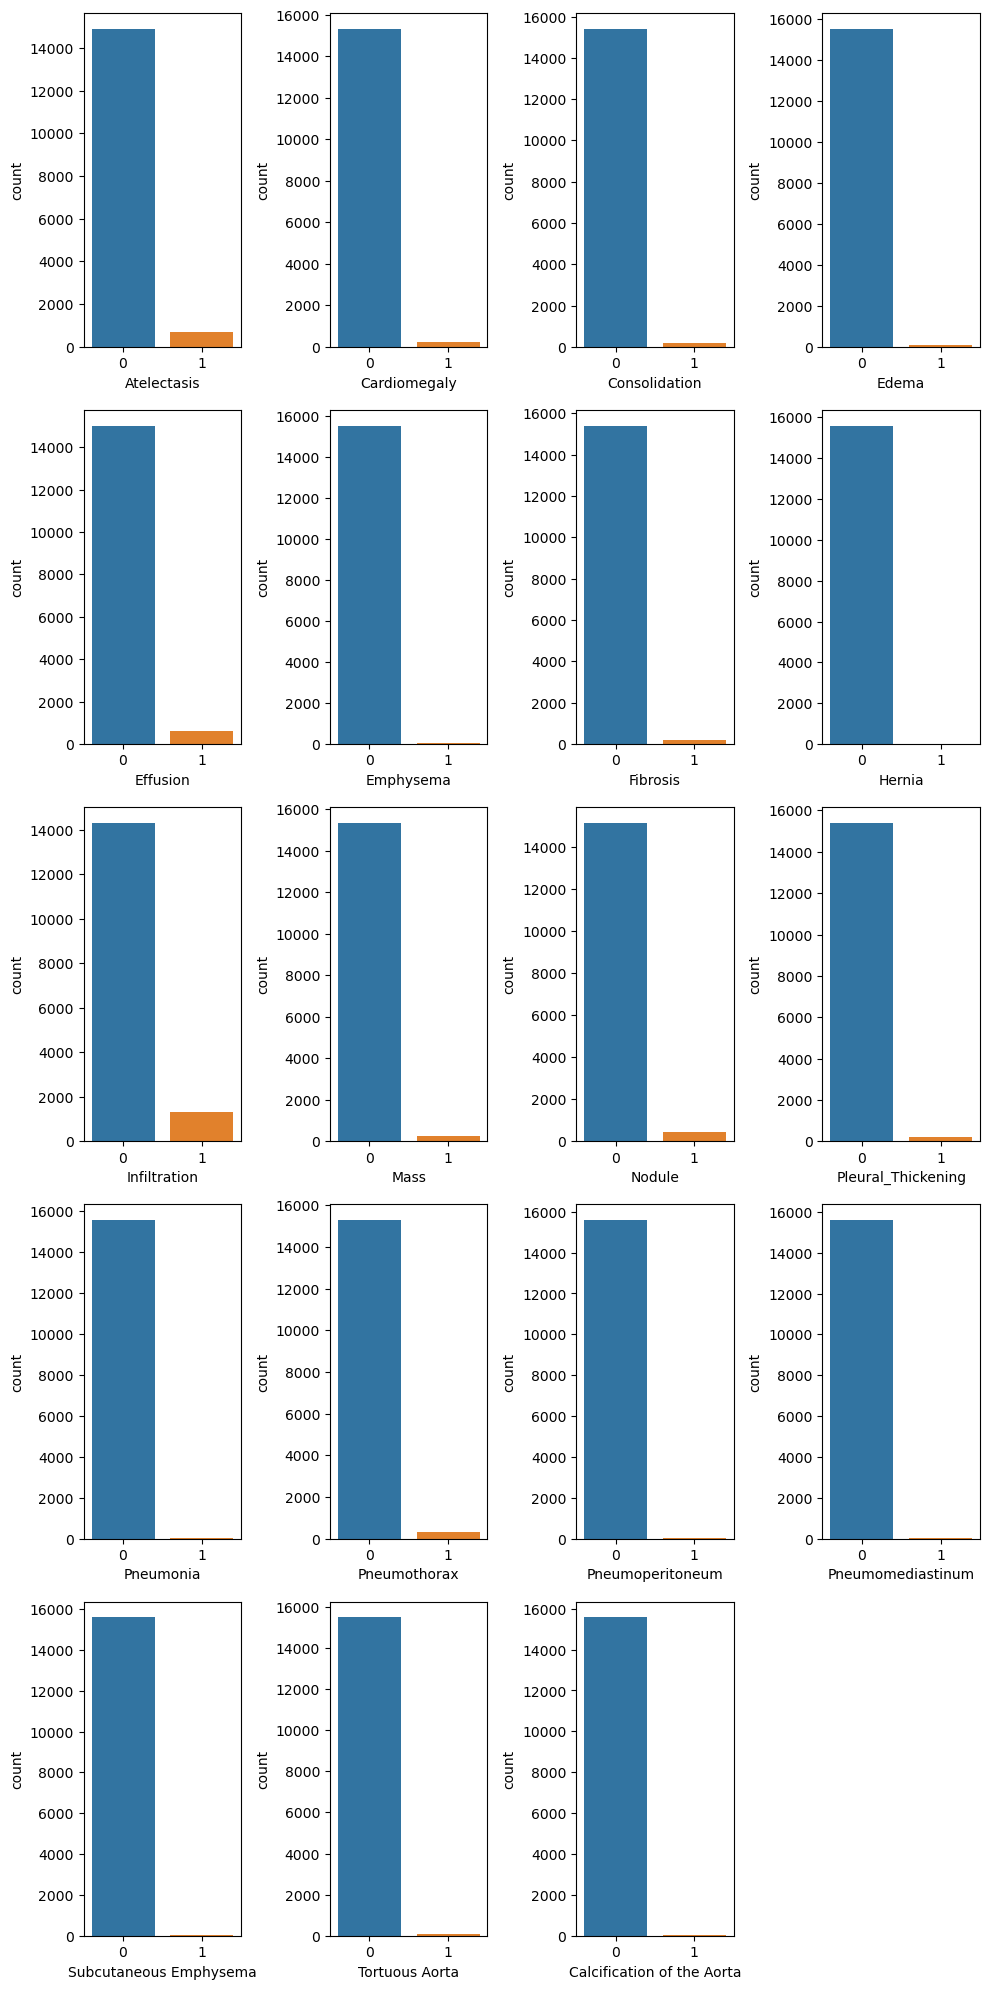

In [7]:
c=train_data.drop(["id","subject_id","No Finding"],axis=1).columns
plt.figure(figsize=(10,20))
for i , j in enumerate(c) :
    plt.subplot(5, 4,i+1)
    sn.countplot(x=train_data[j])

plt.tight_layout() 
"""c=train_data.drop(["id","subject_id"],axis=1).columns
for i in c:
  print(train_data[i].value_counts() )
  print("\n")"""

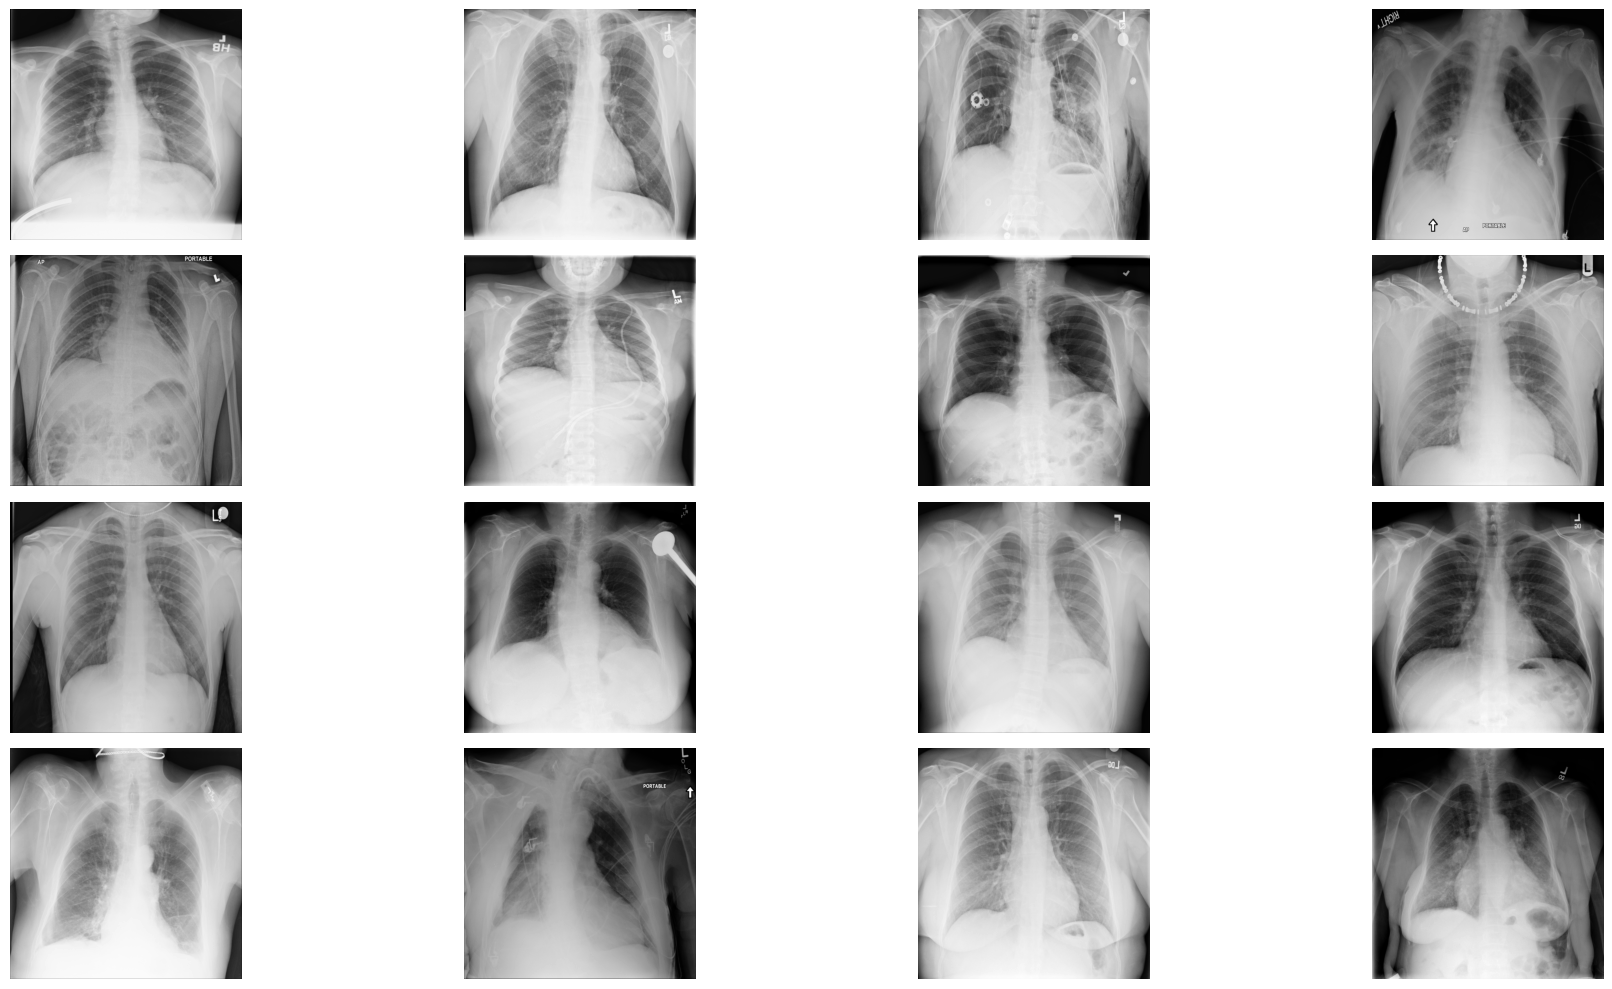

In [8]:
#Plot random images
images = train_data['id'].values
random_images = [np.random.choice(images) for i in range(16)]
img_dir = 'LongTailCXR/images/'

plt.figure(figsize=(20,10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()    

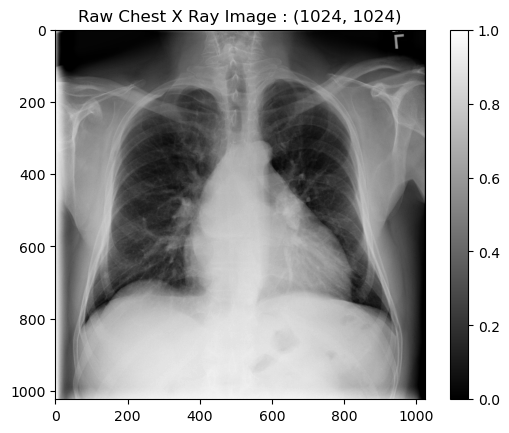

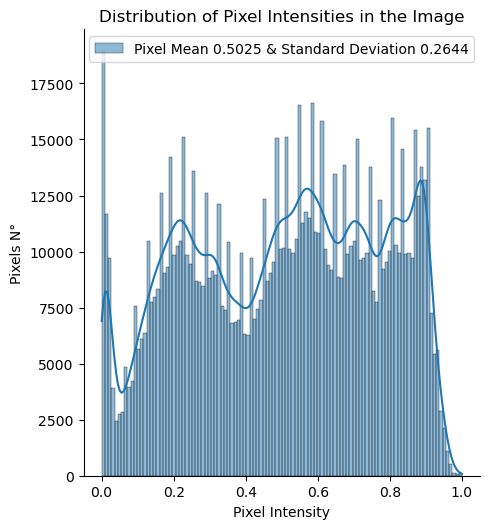

In [9]:
 
def plot_image_distribution(sample_img):
    raw_image = plt.imread(os.path.join(img_dir, sample_img))
    plt.imshow(raw_image, cmap='gray')
    plt.colorbar()
    plt.title(f'Raw Chest X Ray Image : {raw_image.shape}')


    #A histogram of the distribution of the pixels
    sn.displot(raw_image.ravel(), 
                 label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=True)
    plt.legend(loc='upper center')
    plt.title('Distribution of Pixel Intensities in the Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Pixels N°')
    
plot_image_distribution(train_data.id[0])

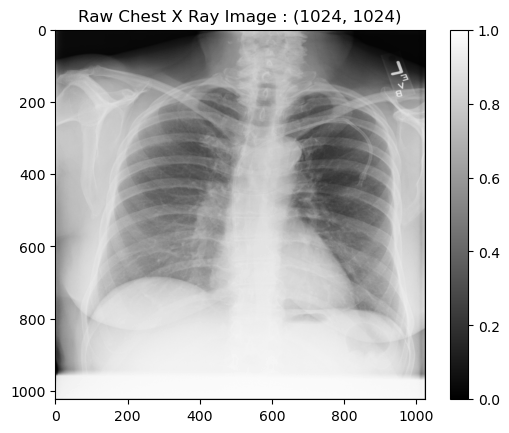

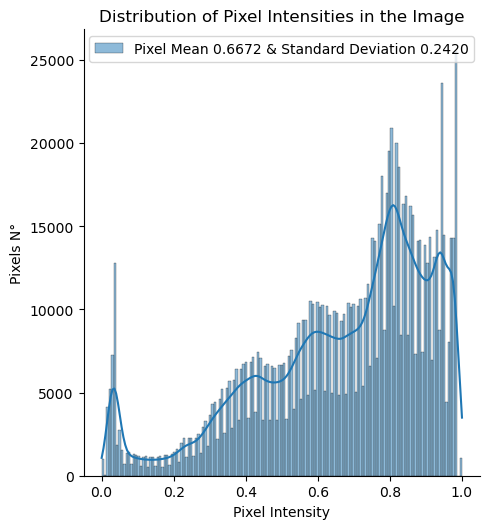

In [10]:
plot_image_distribution(train_data.id[2])

In [11]:
# Normalize images
image_generator = ImageDataGenerator(
    samplewise_center=True, #Set each sample mean to 0.
    samplewise_std_normalization= True # Divide each input by its standard deviation
)

In [12]:
# Flow from directory with specified batch size and target image size
train_generator = image_generator.flow_from_dataframe(
        dataframe=train_data,
        directory="LongTailCXR/images/",
        x_col="id", # features
        y_col= list(c), # labels
        class_mode="raw", # 'Cardiomegaly' column should be in train_data
        batch_size= 1, # images per batch
        shuffle=False, # shuffle the rows or not
        target_size=(320,320) # width and height of output image
)

Found 15598 validated image filenames.


In [13]:
# Flow from directory with specified batch size and target image size
val_generator = image_generator.flow_from_dataframe(
        dataframe=val_data,
        directory="LongTailCXR/images/",
        x_col="id", # features
        y_col= list(c), # labels
        class_mode="raw", # 'Cardiomegaly' column should be in train_data
        batch_size= 1, # images per batch
        shuffle=False, # shuffle the rows or not
        target_size=(320,320) # width and height of output image
)

Found 70 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 1.3732 and the minimum is -2.7158
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


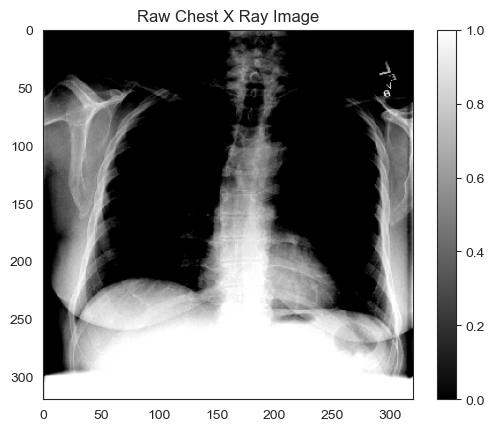

In [14]:
# Plot a processed image
sn.set_style("white")
generated_image, label = train_generator.__getitem__(2)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [32]:
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)



In [33]:
labels = list(c)
# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [34]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, None, None,   0          ['input_2[0][0]']                
 D)                             3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_2[0][0]']       
                                64)                                                     

                                                                                                  
 conv2_block3_concat (Concatena  (None, None, None,   0          ['conv2_block2_concat[0][0]',    
 te)                            160)                              'conv2_block3_2_conv[0][0]']    
                                                                                                  
 conv2_block4_0_bn (BatchNormal  (None, None, None,   640        ['conv2_block3_concat[0][0]']    
 ization)                       160)                                                              
                                                                                                  
 conv2_block4_0_relu (Activatio  (None, None, None,   0          ['conv2_block4_0_bn[0][0]']      
 n)                             160)                                                              
                                                                                                  
 conv2_blo

 n)                             128)                                                              
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, None, None,   16384       ['conv3_block1_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block1_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, None, None,   0          ['conv3_block1_1_bn[0][0]']      
 n)                             128)                                                              
          

 conv3_block5_0_relu (Activatio  (None, None, None,   0          ['conv3_block5_0_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv3_block5_1_conv (Conv2D)   (None, None, None,   32768       ['conv3_block5_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block5_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, None, None,   0          ['conv3_block5_1_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block9_0_relu (Activatio  (None, None, None,   0          ['conv3_block9_0_bn[0][0]']      
 n)                             384)                                                              
                                                                                                  
 conv3_block9_1_conv (Conv2D)   (None, None, None,   49152       ['conv3_block9_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block9_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block9_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_blo

                                512)                                                              
                                                                                                  
 pool3_relu (Activation)        (None, None, None,   0           ['pool3_bn[0][0]']               
                                512)                                                              
                                                                                                  
 pool3_conv (Conv2D)            (None, None, None,   131072      ['pool3_relu[0][0]']             
                                256)                                                              
                                                                                                  
 pool3_pool (AveragePooling2D)  (None, None, None,   0           ['pool3_conv[0][0]']             
                                256)                                                              
          

 conv4_block4_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block4_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, None, None,   0          ['conv4_block4_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, None, None,   36864       ['conv4_block4_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv4_block4_concat (Concatena  (None, None, None,   0          ['conv4_block3_concat[0][0]',    
 te)      

                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block8_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, None, None,   0          ['conv4_block8_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv4_block8_2_conv (Conv2D)   (None, None, None,   36864       ['conv4_block8_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv4_blo

                                128)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block12_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_block12_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block12_1_relu[0][0]']   
                                32)                                                               
          

 conv4_block16_1_conv (Conv2D)  (None, None, None,   94208       ['conv4_block16_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block16_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block16_1_relu (Activati  (None, None, None,   0          ['conv4_block16_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block16_1_relu[0][0]']   
          

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, None, None,   110592      ['conv4_block20_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block20_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block20_1_relu (Activati  (None, None, None,   0          ['conv4_block20_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_blo

 on)                            992)                                                              
                                                                                                  
 conv4_block24_1_conv (Conv2D)  (None, None, None,   126976      ['conv4_block24_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block24_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block24_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block24_1_relu (Activati  (None, None, None,   0          ['conv4_block24_1_bn[0][0]']     
 on)                            128)                                                              
          

 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   36864       ['conv5_block3_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv5_block3_concat (Concatena  (None, None, None,   0          ['conv5_block2_concat[0][0]',    
 te)                            608)                              'conv5_block3_2_conv[0][0]']    
                                                                                                  
 conv5_block4_0_bn (BatchNormal  (None, None, None,   2432       ['conv5_block3_concat[0][0]']    
 ization) 

                                                                                                  
 conv5_block7_1_relu (Activatio  (None, None, None,   0          ['conv5_block7_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv5_block7_2_conv (Conv2D)   (None, None, None,   36864       ['conv5_block7_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv5_block7_concat (Concatena  (None, None, None,   0          ['conv5_block6_concat[0][0]',    
 te)                            736)                              'conv5_block7_2_conv[0][0]']    
                                                                                                  
 conv5_blo

 lization)                      128)                                                              
                                                                                                  
 conv5_block11_1_relu (Activati  (None, None, None,   0          ['conv5_block11_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, None, None,   36864       ['conv5_block11_1_relu[0][0]']   
                                32)                                                               
                                                                                                  
 conv5_block11_concat (Concaten  (None, None, None,   0          ['conv5_block10_concat[0][0]',   
 ate)                           864)                              'conv5_block11_2_conv[0][0]']   
          

 conv5_block15_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block15_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_block15_1_relu (Activati  (None, None, None,   0          ['conv5_block15_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, None, None,   36864       ['conv5_block15_1_relu[0][0]']   
                                32)                                                               
                                                                                                  
 conv5_block15_concat (Concaten  (None, None, None,   0          ['conv5_block14_concat[0][0]',   
 ate)     

In [35]:
len(base_model.layers)

427

In [36]:
conv2D_layers = [layer for layer in base_model.layers 
                if str(type(layer)).find('Conv2D') > -1]

In [37]:
len(conv2D_layers)

120

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


# define the callbacks
checkpoint = ModelCheckpoint('model_weights_1.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)


model = Model(inputs=base_model.input, outputs=predictions)
                                       



In [39]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, None, None,   0          ['input_2[0][0]']                
 D)                             3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_2[0][0]']       
                                64)                                                         

                                                                                                  
 conv2_block3_concat (Concatena  (None, None, None,   0          ['conv2_block2_concat[0][0]',    
 te)                            160)                              'conv2_block3_2_conv[0][0]']    
                                                                                                  
 conv2_block4_0_bn (BatchNormal  (None, None, None,   640        ['conv2_block3_concat[0][0]']    
 ization)                       160)                                                              
                                                                                                  
 conv2_block4_0_relu (Activatio  (None, None, None,   0          ['conv2_block4_0_bn[0][0]']      
 n)                             160)                                                              
                                                                                                  
 conv2_blo

 n)                             128)                                                              
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, None, None,   16384       ['conv3_block1_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block1_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, None, None,   0          ['conv3_block1_1_bn[0][0]']      
 n)                             128)                                                              
          

 conv3_block5_0_relu (Activatio  (None, None, None,   0          ['conv3_block5_0_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv3_block5_1_conv (Conv2D)   (None, None, None,   32768       ['conv3_block5_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block5_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, None, None,   0          ['conv3_block5_1_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block9_0_relu (Activatio  (None, None, None,   0          ['conv3_block9_0_bn[0][0]']      
 n)                             384)                                                              
                                                                                                  
 conv3_block9_1_conv (Conv2D)   (None, None, None,   49152       ['conv3_block9_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block9_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block9_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_blo

                                512)                                                              
                                                                                                  
 pool3_relu (Activation)        (None, None, None,   0           ['pool3_bn[0][0]']               
                                512)                                                              
                                                                                                  
 pool3_conv (Conv2D)            (None, None, None,   131072      ['pool3_relu[0][0]']             
                                256)                                                              
                                                                                                  
 pool3_pool (AveragePooling2D)  (None, None, None,   0           ['pool3_conv[0][0]']             
                                256)                                                              
          

 conv4_block4_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block4_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, None, None,   0          ['conv4_block4_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, None, None,   36864       ['conv4_block4_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv4_block4_concat (Concatena  (None, None, None,   0          ['conv4_block3_concat[0][0]',    
 te)      

                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block8_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, None, None,   0          ['conv4_block8_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv4_block8_2_conv (Conv2D)   (None, None, None,   36864       ['conv4_block8_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv4_blo

                                128)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block12_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_block12_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block12_1_relu[0][0]']   
                                32)                                                               
          

 conv4_block16_1_conv (Conv2D)  (None, None, None,   94208       ['conv4_block16_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block16_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block16_1_relu (Activati  (None, None, None,   0          ['conv4_block16_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block16_1_relu[0][0]']   
          

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, None, None,   110592      ['conv4_block20_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block20_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block20_1_relu (Activati  (None, None, None,   0          ['conv4_block20_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_blo

 on)                            992)                                                              
                                                                                                  
 conv4_block24_1_conv (Conv2D)  (None, None, None,   126976      ['conv4_block24_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block24_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block24_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block24_1_relu (Activati  (None, None, None,   0          ['conv4_block24_1_bn[0][0]']     
 on)                            128)                                                              
          

 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   36864       ['conv5_block3_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv5_block3_concat (Concatena  (None, None, None,   0          ['conv5_block2_concat[0][0]',    
 te)                            608)                              'conv5_block3_2_conv[0][0]']    
                                                                                                  
 conv5_block4_0_bn (BatchNormal  (None, None, None,   2432       ['conv5_block3_concat[0][0]']    
 ization) 

                                                                                                  
 conv5_block7_1_relu (Activatio  (None, None, None,   0          ['conv5_block7_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv5_block7_2_conv (Conv2D)   (None, None, None,   36864       ['conv5_block7_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv5_block7_concat (Concatena  (None, None, None,   0          ['conv5_block6_concat[0][0]',    
 te)                            736)                              'conv5_block7_2_conv[0][0]']    
                                                                                                  
 conv5_blo

 lization)                      128)                                                              
                                                                                                  
 conv5_block11_1_relu (Activati  (None, None, None,   0          ['conv5_block11_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, None, None,   36864       ['conv5_block11_1_relu[0][0]']   
                                32)                                                               
                                                                                                  
 conv5_block11_concat (Concaten  (None, None, None,   0          ['conv5_block10_concat[0][0]',   
 ate)                           864)                              'conv5_block11_2_conv[0][0]']   
          

 conv5_block15_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block15_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_block15_1_relu (Activati  (None, None, None,   0          ['conv5_block15_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, None, None,   36864       ['conv5_block15_1_relu[0][0]']   
                                32)                                                               
                                                                                                  
 conv5_block15_concat (Concaten  (None, None, None,   0          ['conv5_block14_concat[0][0]',   
 ate)     

In [87]:
"""def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight(class_weight ='balanced',classes = [0.,1.], y = y_true[:, i])
    return weights

def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
calculating_class_weights(np.array(train_data[labels]))"""

In [31]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [32]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos


array([4.46211053e-02, 1.63482498e-02, 1.15399410e-02, 4.29542249e-03,
       3.80818054e-02, 4.42364406e-03, 1.31427106e-02, 9.61661752e-04,
       8.36004616e-02, 1.70534684e-02, 2.87216310e-02, 1.32709322e-02,
       2.88498525e-03, 2.04513399e-02, 7.69329401e-04, 6.41107834e-05,
       7.05218618e-04, 6.79574304e-03, 1.60276959e-03])

In [33]:
len(freq_pos)

19

In [34]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0


        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            y_true_float = tf.cast(y_true, tf.float32) # Convert y_true to float32
            loss_pos = -1 * K.mean(pos_weights[i] * y_true_float[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true_float[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        
        return loss
    

    return weighted_loss

In [35]:
pos_weights = freq_neg
neg_weights = freq_pos

In [46]:
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))  
history = model.fit(train_generator, validation_data=val_generator, steps_per_epoch=120, validation_steps=25, epochs=15,
                              callbacks=[checkpoint, early_stop])

Epoch 1/15
120/120 [==============================] - ETA: 0s - loss: 1.0784
Epoch 1: val_loss improved from inf to 8.52362, saving model to model_weights_1.h5
120/120 [==============================] - 296s 2s/step - loss: 1.0784 - val_loss: 8.5236
Epoch 2/15
120/120 [==============================] - ETA: 0s - loss: 0.6811
Epoch 2: val_loss improved from 8.52362 to 6.27707, saving model to model_weights_1.h5
120/120 [==============================] - 226s 2s/step - loss: 0.6811 - val_loss: 6.2771
Epoch 3/15
120/120 [==============================] - ETA: 0s - loss: 0.5544
Epoch 3: val_loss did not improve from 6.27707
120/120 [==============================] - 226s 2s/step - loss: 0.5544 - val_loss: 7.6437
Epoch 4/15
120/120 [==============================] - ETA: 0s - loss: 0.4544
Epoch 4: val_loss did not improve from 6.27707
120/120 [==============================] - 240s 2s/step - loss: 0.4544 - val_loss: 13.6726
Epoch 5/15
120/120 [==============================] - ETA: 0s - los

In [40]:
model.load_weights("./model_weights_1.h5")

In [24]:
test_generator = image_generator.flow_from_dataframe(
        dataframe=test_data,
        directory="LongTailCXR/images/",
        x_col="id", # features
        y_col= list(c), # labels
        class_mode="raw", # 'Cardiomegaly' column should be in train_data
        batch_size= 1, # images per batch
        shuffle=False, # shuffle the rows or not
        target_size=(320,320) # width and height of output image
)

Found 5139 validated image filenames.


C:\Users\Administrateur\anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [50]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))

5139/5139 [==============================] - 1757s 341ms/step


In [49]:
"""# Get a batch of images and corresponding labels from the test generator
x_test, y_test = next(test_generator)

# Get the corresponding predicted labels from predicted_vals
y_pred = predicted_vals[:len(x_test)]

# Choose an image index to plot
img_idx = 0

# Plot the image and its prediction
plt.imshow(x_test[img_idx])
plt.title(f"Predicted labels: {np.round(y_pred[img_idx], decimals=2)}\nTrue labels: {y_test[img_idx]}")
plt.axis("off")
plt.show()"""

'# Get a batch of images and corresponding labels from the test generator\nx_test, y_test = next(test_generator)\n\n# Get the corresponding predicted labels from predicted_vals\ny_pred = predicted_vals[:len(x_test)]\n\n# Choose an image index to plot\nimg_idx = 0\n\n# Plot the image and its prediction\nplt.imshow(x_test[img_idx])\nplt.title(f"Predicted labels: {np.round(y_pred[img_idx], decimals=2)}\nTrue labels: {y_test[img_idx]}")\nplt.axis("off")\nplt.show()'

1/1 [==============================] - 3s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 0, 'Edema': 0, 'Effusion': 0, 'Emphysema': 1, 'Fibrosis': 0, 'Hernia': 0, 'Infiltration': 0, 'Mass': 1, 'Nodule': 1, 'Pleural_Thickening': 1, 'Pneumonia': 0, 'Pneumothorax': 1, 'Pneumoperitoneum': 0, 'Pneumomediastinum': 0, 'Subcutaneous Emphysema': 0, 'Tortuous Aorta': 1, 'Calcification of the Aorta': 1}
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]]


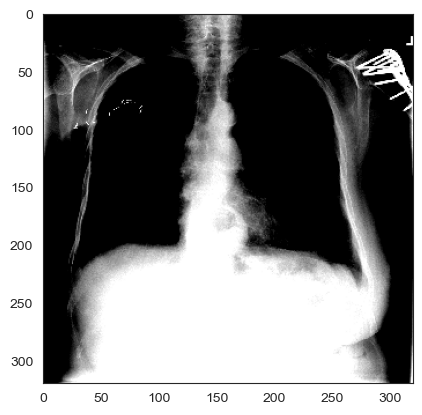

In [47]:
# Index of the image 
index = 0

# Get the corresponding image and label
img, label = test_generator[index]

# Get the prediction for the image
pred = model.predict(img)

pred_classes = dict(zip(labels,list((np.array(pred) > 0.5).astype(int)[0])))
print(pred_classes)
print(label)
# Plot the image with the label and prediction as the title
plt.imshow(img[0])
plt.show()

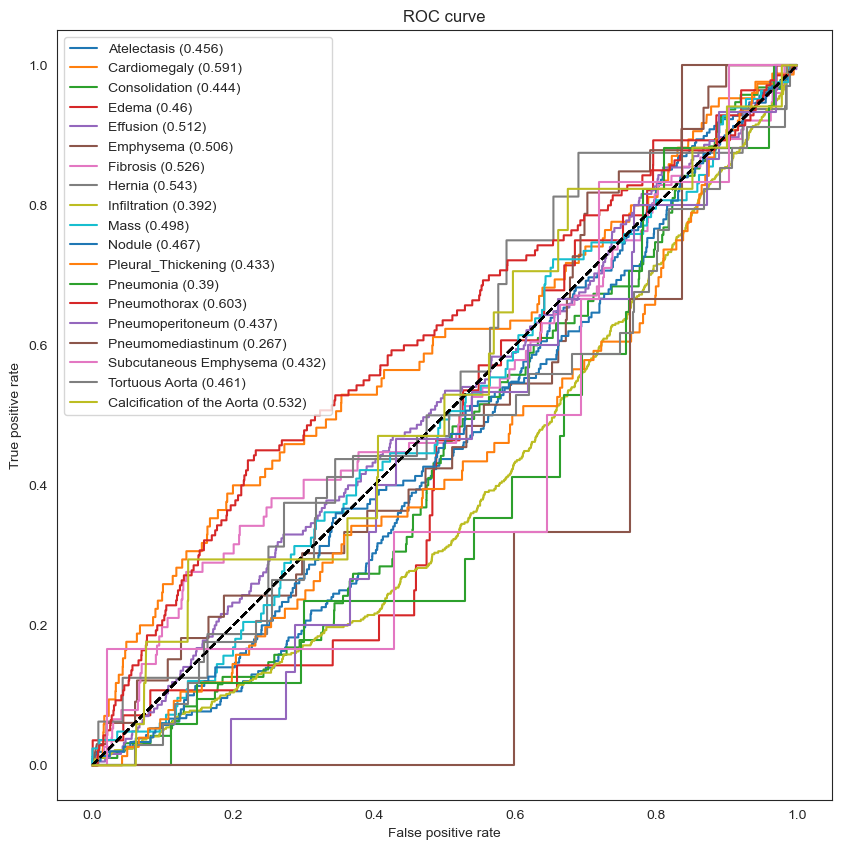

In [55]:

auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [70]:
test_data[(test_data['Cardiomegaly'] == 1) & (test_data.iloc[:, 1:-1].sum(axis=1) == 1)] # images that contains only Cardiomegaly

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subject_id
13,00000038_003.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,38
36,00000075_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,75
37,00000075_001.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,75
74,00000116_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,116
87,00000116_016.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4955,00006386_007.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6386
5015,00006481_005.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6481
5019,00006481_015.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6481
5028,00006481_032.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6481


In [66]:
#investigate how the model identifies Cardiomegaly

index = 13 # refers to the id of an image that contains only Cardiomegaly
img, label = test_generator[index]
data = ([img[0]], None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=1)  # Cardiomecaly columns = index 1

explainer.save(grid, ".", "grad_cam_Cardiomegaly.png")

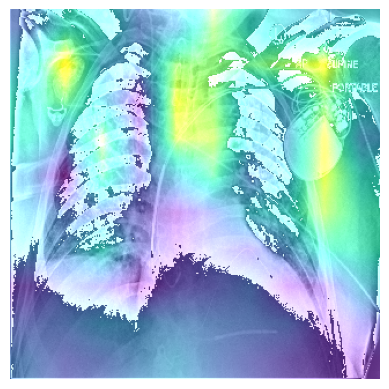

In [67]:
import matplotlib.image as mpimg

# Load the image file
img = mpimg.imread('grad_cam_Cardiomegaly.png')

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

### Now we'll use a pretrained model on 40GB+ dataset 

In [104]:
"""model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights("./pretrained_model(1).h5")"""

'model = Model(inputs=base_model.input, outputs=predictions)\nmodel.load_weights("./pretrained_model(1).h5")'